In [1]:
import os
import json

import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt

from linear_modeling import *

### Load data and sample metadata

In [2]:
data_path = os.path.join(
    os.getcwd(),
    "..",
    "data",
    "S_cereviseae_compendia_recount_bio_2022_03_16"
)

In [3]:
with open(
        os.path.join(data_path, 'aggregated_metadata.json'), 'r') as jsonfile:
    metadata_file = json.load(jsonfile)

tables = {}
for k, v in metadata_file['experiments'].items():
    tables[v["accession_code"]] = v
    
metadata = pd.DataFrame(tables).T

In [4]:
data = pd.read_csv(os.path.join(data_path, "SACCHAROMYCES_CEREVISIAE.tsv"), sep="\t", header=0, index_col=0).T
print("Loaded data with dimensions:", str(data.shape))

Loaded data with dimensions: (12428, 5370)


### Load gene metadata

In [33]:
# Get metadata for genes and extract genes with "transporter" annotation
gene_mapper = pd.read_csv(os.path.join(
    os.getcwd(),
    "..",
    "data",
    "yeast_orf_dict.csv"
), header=None, names=["id", "symbol", "name", "description"])

transporters = gene_mapper.loc[gene_mapper["description"].str.contains("transporter")]
transporters_list = transporters["id"].tolist()

In [42]:
gene_map = {}
for i, r in gene_mapper.iterrows():
    _id = str(r["id"])
    _name = str(r["symbol"])
    if _name != "nan":
        gene_map[_id] = _name
    else:
        gene_map[_id] = _id

In [6]:
# Get ID for transporter
_name = "CTP1"
_this = transporters.loc[transporters["symbol"] == _name]["id"].tolist()[0]

In [7]:
def split_data(data, label_names, test_fraction=0.2, random_state=42):
    """Split input data into training and testing sets
    
    data        <pd.DataFrame> : Expects dataframe with genes as columns and samples as rows
    label_names <array>        : List of name(s) that are labels
    """
    
    test = data.sample(
        frac=test_fraction, 
        random_state=random_state,
        axis=0)
    train = data.loc[~data.index.isin(test.index)]
    
    X_test = test[test.columns.difference(label_names)]
    y_test = test[label_names]
    
    X_train = train[train.columns.difference(label_names)]
    y_train = train[label_names]
    
    feature_labels = [X_test.columns.tolist(), y_test.columns.tolist()]
    
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test), feature_labels

In [8]:
X_train, X_test, y_train, y_test, feature_labels = split_data(data, [_this], test_fraction=0.3)

Initializing zero weights...
Performing MAP estimation with Newton-Raphson solver...
	Iteration: 1, Change in weights: 7.204, MSE: 2078.63816
	Iteration: 2, Change in weights: 2938.024, MSE: 3371.90173
	Iteration: 3, Change in weights: 37113.022, MSE: 2467.93706
	Iteration: 4, Change in weights: 199469.932, MSE: 1518.65288
	Iteration: 5, Change in weights: 906304.173, MSE: 1516.10095
	Iteration: 6, Change in weights: 185.245, MSE: 1516.10095
	Iteration: 7, Change in weights: 0.0, MSE: 1516.10095
Training complete.


Text(0, 0.5, 'MSE')

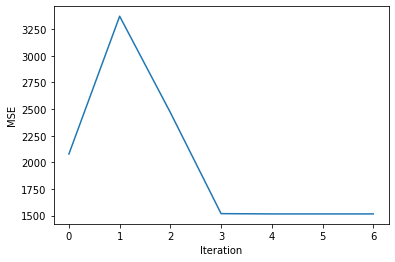

In [13]:
final_weights1, mse_record = newton_solver(
    training_data=X_train, 
    training_labels=y_train, 
    test_data=X_test, 
    test_labels=y_test, 
    initialization_type="zero", 
    regression_type="logistic")

plt.plot([i for i in range(len(mse_record))], mse_record)
plt.xlabel("Iteration")
plt.ylabel("MSE")

Initializing random weights...
Performing MAP estimation with Newton-Raphson solver...
	Iteration: 1, Change in weights: 15129.282, MSE: 2481.2024
	Iteration: 2, Change in weights: 76658.61, MSE: 2060.26032
	Iteration: 3, Change in weights: 1077771.235, MSE: 1516.10095
	Iteration: 4, Change in weights: 164053.794, MSE: 1516.10095
	Iteration: 5, Change in weights: 0.0, MSE: 1516.10095
Training complete.


Text(0, 0.5, 'MSE')

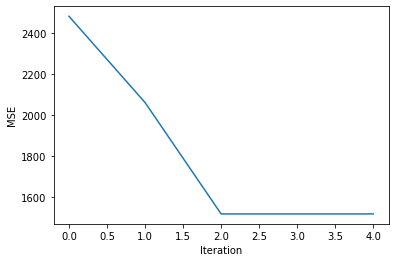

In [14]:
final_weights2, mse_record = newton_solver(
    training_data=X_train, 
    training_labels=y_train, 
    test_data=X_test, 
    test_labels=y_test, 
    initialization_type="random", 
    regression_type="logistic",
    gaussian_sd=0.2)

plt.plot([i for i in range(len(mse_record))], mse_record)
plt.xlabel("Iteration")
plt.ylabel("MSE")

Initializing random weights...
Performing MAP estimation with Newton-Raphson solver...
	Iteration: 1, Change in weights: 79476.684, MSE: 1656.97597
	Iteration: 2, Change in weights: 393764.617, MSE: 1516.10095
	Iteration: 3, Change in weights: 837496.034, MSE: 1516.10095
	Iteration: 4, Change in weights: 0.0, MSE: 1516.10095
Training complete.


Text(0, 0.5, 'MSE')

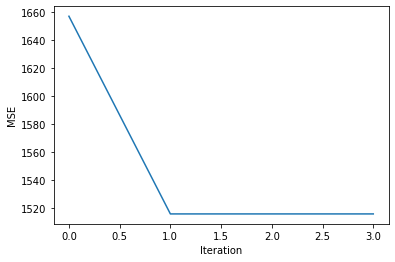

In [15]:
final_weights3, mse_record = newton_solver(
    training_data=X_train, 
    training_labels=y_train, 
    test_data=X_test, 
    test_labels=y_test, 
    initialization_type="random", 
    regression_type="logistic",
    gaussian_sd=0.2,
    regularizer=2)

plt.plot([i for i in range(len(mse_record))], mse_record)
plt.xlabel("Iteration")
plt.ylabel("MSE")

Initializing random weights...
Performing MAP estimation with Newton-Raphson solver...
	Iteration: 1, Change in weights: 244402.626, MSE: 1606.69532
	Iteration: 2, Change in weights: 947217.697, MSE: 1516.10095
	Iteration: 3, Change in weights: 24380.398, MSE: 1516.10095
	Iteration: 4, Change in weights: 0.0, MSE: 1516.10095
Training complete.


Text(0, 0.5, 'MSE')

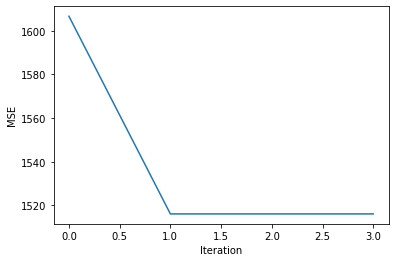

In [16]:
final_weights4, mse_record = newton_solver(
    training_data=X_train, 
    training_labels=y_train, 
    test_data=X_test, 
    test_labels=y_test, 
    initialization_type="random", 
    regression_type="logistic",
    gaussian_sd=0.2,
    regularizer=0.2)

plt.plot([i for i in range(len(mse_record))], mse_record)
plt.xlabel("Iteration")
plt.ylabel("MSE")

In [19]:
np.min(final_weights1)

232.20420595642872

In [ ]:
data.corr()[_this].sort_values()

In [51]:
weights_matrix = pd.DataFrame(final_weights1, index=feature_labels[0], columns=["weights"])
weights_matrix.index = weights_matrix.index.to_series().map(gene_map).tolist()

In [53]:
weights_matrix.sort_values(by="weights", ascending=False).head(30)

,weights
TDH3,56374.747316
CCW12,55050.693238
FBA1,53015.769520
ENO2,51831.608948
RPS31,49551.004784
ADH1,48897.916718
RPL25,48498.442100
RPS3,48452.582248
GPM1,48299.667898
PDC1,47592.132948


In [ ]:
# a lot of structural components - worried these might be biased factors

In [ ]:
# try single or batch regression, see if this gives better gene prioritization